In [1]:
!pwd

/home/alan_khang/adam_sandbox


In [1]:
import os
import sys
import glob
import pickle
import cv2
import numpy as np
import json
import time
import math
from scipy.spatial.transform import Rotation as R
from pyquaternion import Quaternion

from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import Box
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.detection.evaluate import NuScenesEval 
from nuscenes.eval.detection.config import config_factory

from mmdet3d.datasets.convert_utils import post_process_coords
from mmdet3d.structures.bbox_3d.utils import points_cam2img 

In [2]:
import pickle

data = {
    'metainfo': {
        'categories': {'guilder': 0},
        'dataset': 'adam_project',
        'version': '',
        'info_version': ''
    },
    'data_list': []
}


In [3]:
img_dir = '/home/alan_khang/Downloads/guilder_dataset/images'
annot_dir = '/home/alan_khang/Downloads/guilder_dataset/annotations'

In [4]:
def get_corners(center, whl, pitch_angle, whl_factor: float = 1.0) -> np.ndarray:
    """
    Returns the bounding box corners.
    :param wlh_factor: Multiply w, l, h by a factor to scale the box.
    :return: <np.float: 3, 8>. First four corners are the ones facing forward.
        The last four are the ones facing backwards.
    """
    w, h, l = whl * whl_factor

    # 3D bounding box corners. (Convention: x to the right, y down, z points forward.)
    x_corners = w / 2 * np.array([-1, 1, 1, -1, -1, 1, 1, -1])
    y_corners = h / 2 * np.array([-1, -1, 1, 1, -1, -1, 1, 1])
    z_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    corners = np.vstack((x_corners, y_corners, z_corners))

    # Rotate
    rot_mat = R.from_euler('y', pitch_angle, degrees=True).as_matrix()
    corners = np.dot(rot_mat, corners)

    # Translate
    x, y, z = center
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z

    return corners


In [5]:
img_files = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
cam_name = 'CAM_FRONT'

cnt = 0

for i, img_path in enumerate(img_files):
    img_filename = os.path.basename(img_path)
    assert img_filename.endswith('.jpg'), f"Expected .jpg file, got {img_filename}"
    annot_file = os.path.join(annot_dir, img_filename.replace('.jpg', '.json'))

    with open(annot_file, 'r') as f:
        annot = json.load(f)

    camera_intr = np.array(annot['camera_intrinsic'])
    aruco_orientation = np.array(annot['aruco_orientation'])
    guilder_whl = np.array(annot['guilder_whl']) 
    guilder_center = np.array(annot['guiler_center'])
    pitch_angle_deg = annot['aruco_pitch_deg']  
    pitch_angle_rad = annot['aruco_pitch_rad']

    #box = Box(guilder_center, guilder_whl, Quaternion(aruco_orientation), velocity=np.zeros(3).tolist())

    corners_3d = get_corners(guilder_center, guilder_whl, -pitch_angle_deg)
    in_front = np.argwhere(corners_3d[2, :] > 0).flatten()
    corners_3d = corners_3d[:, in_front]

    # Project 3d box to 2d.
    corner_coords = view_points(corners_3d, camera_intr,
                                True).T[:, :2].tolist()

    # Keep only corners that fall within the image.
    final_coords = post_process_coords(corner_coords)

    # Skip if the convex hull of the re-projected corners
    # does not intersect the image canvas.
    if final_coords is None:
        continue
    else:
        min_x, min_y, max_x, max_y = final_coords

    image_info = {
        cam_name: {
            'img_path': img_filename,
            'cam2img': camera_intr.tolist(),
            'cam2ego': np.eye(4).tolist(),  
            'sample_data_token': 'sample_data_' + str(i),
            'timestamp': time.time(),
            'lidar2cam': np.eye(4).tolist(),
        }
    }

    loc = guilder_center.tolist()

    guilder_lhw = guilder_whl.copy()
    guilder_lhw[[0, 1, 2]] = guilder_lhw[[2, 1, 0]]  # convert whl to lhw
    dim = guilder_lhw.tolist()
    #dim[[0, 1, 2]] = dim[[1, 2, 0]]  # convert wlh to our lhw

    rot = [-(math.pi / 2 + pitch_angle_rad)]
    #rot = [box.orientation.yaw_pitch_roll[1]]  
    #rot = [-(math.pi / 2)]

    center_3d = np.array(loc).reshape([1, 3])
    center_2d_with_depth = points_cam2img(center_3d, camera_intr, with_depth=True)
    center_2d_with_depth = center_2d_with_depth.squeeze().tolist()

    cam_instances = {
        cam_name: [{
            'bbox_label': 0, 
            'bbox_label_3d': 0, 
            'bbox': [min_x, min_y, max_x, max_y], 
            'bbox_3d_isvalid': True, 
            'bbox_3d': loc + dim + rot, 
            'velocity': [0., 0.], 
            'center_2d': center_2d_with_depth[:2], 
            'depth': center_2d_with_depth[2], 
            'attr_label': 0
        }]
    }

    data_sample = {
        'sample_idx': i,
        'token': 'sample_' + str(i),
        'timestamp': time.time(),
        'ego2global': np.eye(4).tolist(),   
        'images': image_info,
        'cam_instances': cam_instances
    }

    data['data_list'].append(data_sample)

pkl_path = '/home/alan_khang/Downloads/guilder_dataset/guilder_infos_train.pkl'

# Save to .pkl file
with open(pkl_path, 'wb') as f:
    pickle.dump(data, f)

In [6]:
import pickle
import math

pkl_path = '/home/alan_khang/Downloads/guilder_dataset/guilder_infos_train.pkl'

with open(pkl_path, 'rb') as f:
    guilder_data = pickle.load(f)

In [7]:
guilder_data['data_list'][100]['cam_instances']  

{'CAM_FRONT': [{'bbox_label': 0,
   'bbox_label_3d': 0,
   'bbox': [170.75036206857416,
    125.23677824113082,
    354.989758093126,
    233.97840111063496],
   'bbox_3d_isvalid': True,
   'bbox_3d': [-0.1757194080691825,
    -0.06432308583040061,
    1.6484563829754069,
    0.515,
    0.343,
    0.58,
    -1.4089035463693762],
   'velocity': [0.0, 0.0],
   'center_2d': [274.4594421386719, 183.32962036132812],
   'depth': 1.648456335067749,
   'attr_label': 0}]}

In [8]:
guilder_data

{'metainfo': {'categories': {'guilder': 0},
  'dataset': 'adam_project',
  'version': '',
  'info_version': ''},
 'data_list': [{'sample_idx': 0,
   'token': 'sample_0',
   'timestamp': 1753866597.9663014,
   'ego2global': [[1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]],
   'images': {'CAM_FRONT': {'img_path': 'frame_000000.jpg',
     'cam2img': [[427.2243957519531, 0.0, 320.0],
      [0.0, 427.2243957519531, 200.0],
      [0.0, 0.0, 1.0]],
     'cam2ego': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]],
     'sample_data_token': 'sample_data_0',
     'timestamp': 1753866597.9653006,
     'lidar2cam': [[1.0, 0.0, 0.0, 0.0],
      [0.0, 1.0, 0.0, 0.0],
      [0.0, 0.0, 1.0, 0.0],
      [0.0, 0.0, 0.0, 1.0]]}},
   'cam_instances': {'CAM_FRONT': [{'bbox_label': 0,
      'bbox_label_3d': 0,
      'bbox': [257.28571169390733,
       46.428564823522656,
       588.7142945411662,
  

In [9]:
dataset_root = '/home/alan_khang/Downloads/guilder_dataset'

In [10]:
attribute_table = [{
    "token": "attribute_0",
    "name": "guilder",
    "description": "guilder"
}]

if os.path.exists(os.path.join(dataset_root, 'attribute.json')):
    os.remove(os.path.join(dataset_root, 'attribute.json'))

with open(os.path.join(dataset_root, 'attribute.json'), 'w') as f:
    json.dump(attribute_table, f, indent=4)

In [11]:
calibrated_sensor_table = [{
    "token": "cs_0",
    "sensor_token": "ss_0",
    "translation": [
        0.0,
        0.0,
        0.0],
    "rotation": [
        1.0, 
        0.0, 
        0.0, 
        0.0],
    "camera_intrinsic": [
        [427.2243957519531, 0.0, 320.0],
        [0.0, 427.2243957519531, 200.0],
        [0.0, 0.0, 1.0]
]}]

if os.path.exists(os.path.join(dataset_root, 'calibrated_sensor.json')):
    os.remove(os.path.join(dataset_root, 'calibrated_sensor.json'))

with open(os.path.join(dataset_root, 'calibrated_sensor.json'), 'w') as f:
    json.dump(calibrated_sensor_table, f, indent=4)

In [12]:
category_table = [{
    "token": "cat_0",
    "name": "guilder",
    "description": "guilder"
}]

if os.path.exists(os.path.join(dataset_root, 'category.json')):
    os.remove(os.path.join(dataset_root, 'category.json'))

with open(os.path.join(dataset_root, 'category.json'), 'w') as f:
    json.dump(category_table, f, indent=4)

In [13]:
log_table = [{
    "token": "log_0",
    "logfile": "...",
    "vehicle": "...",
    "date_captured": "...",
    "location": "..."
}]

if os.path.exists(os.path.join(dataset_root, 'log.json')):
    os.remove(os.path.join(dataset_root, 'log.json'))

with open(os.path.join(dataset_root, 'log.json'), 'w') as f:
    json.dump(log_table, f, indent=4)

In [14]:
map_table = [{
    "category": "semantic_prior",
    "token": "map_0",
    "filename": "maps/map.png",
    "log_tokens": [
        "log_0"
    ]
}]

if os.path.exists(os.path.join(dataset_root, 'map.json')):
    os.remove(os.path.join(dataset_root, 'map.json'))

with open(os.path.join(dataset_root, 'map.json'), 'w') as f:
    json.dump(map_table, f, indent=4)

In [15]:
sensor_table = [{
    "token": "ss_0",
    "channel": "CAM_FRONT",
    "modality": "camera"
}]

if os.path.exists(os.path.join(dataset_root, 'sensor.json')):
    os.remove(os.path.join(dataset_root, 'sensor.json'))

with open(os.path.join(dataset_root, 'sensor.json'), 'w') as f:
    json.dump(sensor_table, f, indent=4)

In [16]:
visibility_table = [{
    "description": "visibility of whole object is between 80 and 100%",
    "token": "vis_0",
    "level": "v80-100"
}]

if os.path.exists(os.path.join(dataset_root, 'visibility.json')):
    os.remove(os.path.join(dataset_root, 'visibility.json'))

with open(os.path.join(dataset_root, 'visibility.json'), 'w') as f:
    json.dump(visibility_table, f, indent=4)

In [17]:
ego_pose_table = []
instance_table = []
sample_table = []
sample_annotation_table = []
sample_data_table = []
scene_table = []

In [18]:
img_files = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))
cam_name = 'CAM_FRONT'

sample_token_list = []

cnt = 0

for i, img_path in enumerate(img_files):
    img_filename = os.path.basename(img_path)
    assert img_filename.endswith('.jpg'), f"Expected .jpg file, got {img_filename}"
    annot_file = os.path.join(annot_dir, img_filename.replace('.jpg', '.json'))

    with open(annot_file, 'r') as f:
        annot = json.load(f)

    ego_pose_dict = {
        "token": "ego_pose_" + str(i),
        "translation": [0.0, 0.0, 0.0],
        "rotation": [1.0, 0.0, 0.0, 0.0],
        "timestamp": time.time(),
        "log_token": "log_0"
    }

    instance_dict = {
        "token": "ins_" + str(i),
        "category_token": "cat_0",
        "nbr_annotations": 1,
        "first_annotation_token": "annot_" + str(i),
        "last_annotation_token": "annot_" + str(i)
    }

    sample_dict = {
        "token": "sample_" + str(i),
        "timestamp": time.time(),
        "scene_token": "scene_0",
        "next": "",
        "prev": ""
    }

    sample_data_dict = {
        "token": "sample_data_" + str(i),
        "sample_token": "sample_" + str(i),
        "ego_pose_token": "ego_pose_" + str(i),
        "calibrated_sensor_token": "cs_0",
        "filename": 'images/' + img_filename,
        "fileformat": "jpg",
        "width": 640,
        "height": 400,
        "timestamp": time.time(),              
        "is_key_frame": False,
        "next": "",
        "prev": ""
    }

    camera_intr = np.array(annot['camera_intrinsic'])
    aruco_orientation = np.array(annot['aruco_orientation'])
    guilder_whl = np.array(annot['guilder_whl'])
    guilder_center = np.array(annot['guiler_center'])
    pitch_angle_deg = annot['aruco_pitch_deg']

    #guilder_lwh = np.array([guilder_whl[2], guilder_whl[0], guilder_whl[1]])  # convert wlh to lhw
    guilder_wlh = np.array([guilder_whl[0], guilder_whl[2], guilder_whl[1]])  # convert wlh to lhw

    #mmdet3d_bbox_coord_in_nuscenes_coord = np.array([
    #    [0., 0., 1.],
    #    [-1., 0., 0.],
    #    [0., -1., 0.],
    #])
    #mmdet3d_bbox_coord_in_nuscenes_coord = np.eye(3)
    
    quat = R.from_euler('y', -pitch_angle_deg, degrees=True).as_quat(scalar_first=True).squeeze()
    #rot_mat = np.eye(3)
    #orientation_in_nuscenes_format = rot_mat @ mmdet3d_bbox_coord_in_nuscenes_coord.T 
    #orientation_in_nuscenes_format = R.from_matrix(orientation_in_nuscenes_format).as_quat(scalar_first=True).squeeze()

    #guilder_center = mmdet3d_bbox_coord_in_nuscenes_coord @ guilder_center

    sample_annotation_dict = {
        "token": "sample_annotation_" + str(i),
        "sample_token": "sample_" + str(i),
        "instance_token": "ins_" + str(i),
        "attribute_tokens": ["attribute_0"],
        "visibility_token": "vis_0",
        "translation": guilder_center.tolist(),
        "size": guilder_wlh.tolist(),
        "rotation": quat.tolist(),
        "num_lidar_pts": 0,
        "num_radar_pts": 0,
        "next": "",
        "prev": ""
    }

    ego_pose_table.append(ego_pose_dict)
    instance_table.append(instance_dict)
    sample_table.append(sample_dict)
    sample_annotation_table.append(sample_annotation_dict)
    sample_data_table.append(sample_data_dict)

    sample_token_list.append("sample_" + str(i))

if os.path.exists(os.path.join(dataset_root, 'ego_pose.json')):
    os.remove(os.path.join(dataset_root, 'ego_pose.json'))  

with open(os.path.join(dataset_root, 'ego_pose.json'), 'w') as f:
    json.dump(ego_pose_table, f, indent=4)

if os.path.exists(os.path.join(dataset_root, 'instance.json')):
    os.remove(os.path.join(dataset_root, 'instance.json'))

with open(os.path.join(dataset_root, 'instance.json'), 'w') as f:
    json.dump(instance_table, f, indent=4)

if os.path.exists(os.path.join(dataset_root, 'sample.json')):  
    os.remove(os.path.join(dataset_root, 'sample.json'))

with open(os.path.join(dataset_root, 'sample.json'), 'w') as f:
    json.dump(sample_table, f, indent=4)

if os.path.exists(os.path.join(dataset_root, 'sample_annotation.json')):
    os.remove(os.path.join(dataset_root, 'sample_annotation.json'))

with open(os.path.join(dataset_root, 'sample_annotation.json'), 'w') as f:
    json.dump(sample_annotation_table, f, indent=4)

if os.path.exists(os.path.join(dataset_root, 'sample_data.json')):
    os.remove(os.path.join(dataset_root, 'sample_data.json'))

with open(os.path.join(dataset_root, 'sample_data.json'), 'w') as f:
    json.dump(sample_data_table, f, indent=4)

if os.path.exists(os.path.join(dataset_root, 'scene.json')):
    os.remove(os.path.join(dataset_root, 'scene.json'))

if len(sample_token_list) > 0:
    scene_dict = {
        "token": "scene_0",
        "name": "scene_jb",
        "description": "...",
        "log_token": "log_0",
        "nbr_samples": len(sample_token_list),
        "first_sample_token": sample_token_list[0],
        "last_sample_token": sample_token_list[-1]
    }

    with open(os.path.join(dataset_root, 'scene.json'), 'w') as f:
        json.dump([scene_dict], f, indent=4) 

In [19]:
dataset_root = '/home/alan_khang/Downloads/guilder_dataset'

nusc = NuScenes(
    version='', 
    dataroot=dataset_root, 
    verbose=True)

Loading NuScenes tables for version ...
1 category,
1 attribute,
1 visibility,
200 instance,
1 sensor,
1 calibrated_sensor,
200 ego_pose,
1 log,
1 scene,
200 sample,
200 sample_data,
200 sample_annotation,
1 map,
Done loading in 0.004 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [20]:
nusc.get('sample_annotation', 'sample_annotation_0')

{'token': 'sample_annotation_0',
 'sample_token': 'sample_0',
 'instance_token': 'ins_0',
 'attribute_tokens': ['attribute_0'],
 'visibility_token': 'vis_0',
 'translation': [0.18025000552536227,
  -0.09725000098509809,
  1.0051426728133641],
 'size': [0.58, 0.515, 0.343],
 'rotation': [0.9999999999999999, 0.0, 1.6660004686562638e-08, 0.0],
 'num_lidar_pts': 0,
 'num_radar_pts': 0,
 'next': '',
 'prev': '',
 'category_name': 'guilder'}

In [21]:
math.pi / 2 + (-1.3159473397871178)

0.2548489870077788

In [22]:
quat = Quaternion(axis=[0, 1, 0], angle=math.pi / 2 + (-1.3159473397871178))

In [23]:
quat.yaw_pitch_roll[0]

0.0

In [24]:
math.degrees(Quaternion([0.9636268326504216, 0.0, 0.2672514310459654, 0.0]).yaw_pitch_roll[1])

31.001552453960045

In [25]:
def angle_diff(x: float, y: float, period=2*math.pi) -> float:
    """
    Get the smallest angle difference between 2 angles: the angle from y to x.
    :param x: To angle.
    :param y: From angle.
    :param period: Periodicity in radians for assessing angle difference.
    :return: <float>. Signed smallest between-angle difference in range (-pi, pi).
    """

    # calculate angle difference, modulo to [0, 2*pi]
    diff = (x - y + period / 2) % period - period / 2
    if diff > np.pi:
        diff = diff - (2 * np.pi)  # shift (pi, 2*pi] to (-pi, 0]

    return diff

In [26]:
box_list[0].orientation.yaw_pitch_roll[1]  

NameError: name 'box_list' is not defined

In [29]:
data_sample_token = 'sample_data_50'

data_path, box_list, cam_intr = nusc.get_sample_data(data_sample_token)

In [30]:
data_path

'/home/alan_khang/Downloads/guilder_dataset/images/frame_000058.jpg'

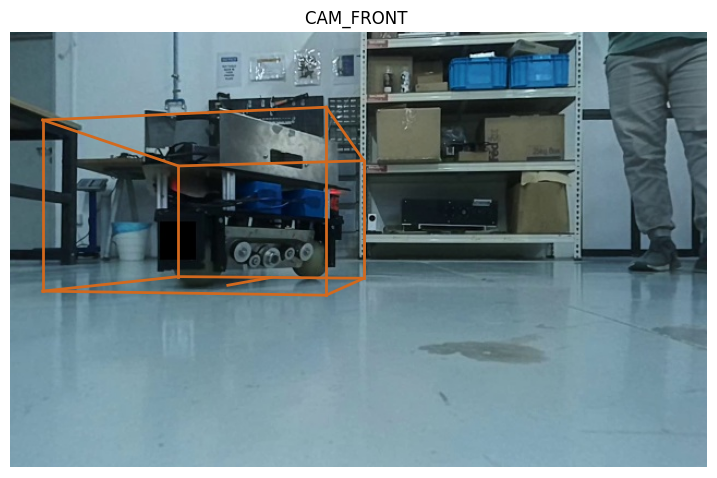

In [31]:
nusc.render_sample_data(data_sample_token)